In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

In [2]:
from argparse import Namespace
import pickle

import pyro
from pyro import distributions as dist
import torch
from torch.distributions import constraints

from src.pgm import utils

pyro.enable_validation(True)

![](https://miro.medium.com/max/1400/0*Ws_1F7ZFdbqph4Y8.)

$$\mathbb{P}(\texttt{Difficulty} = d) \sim \texttt{Bernoulli}(\theta^D),\; d \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Intelligence} = i) \sim  \texttt{Bernoulli}(\theta^I),\; i \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Grade} = g\; |\; \texttt{Difficulty} = d, \texttt{Intelligence} = i) \sim \texttt{Cat}(\theta^G_{d, i}),\; g \in \{0, 1, 2\}$$

$$\mathbb{P}(\texttt{SAT} = s\; |\; \texttt{Intelligence} = i) \sim \texttt{Bernoulli}(\theta^S_i),\; s \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Letter} = l \;|\; \texttt{Grade} = g) \sim \texttt{Bernoulli}(\theta^L_g),\; l \in \{0, 1\}$$

# Homework (part 3)

## Prepare model and guide
- Implement the above given model.
- Select initial parameter values $\theta$, so that each outcome is equally probable.

In [3]:
pyro.clear_param_store()

def model(x):
    dif_param,inte_param,sat_param,grade_param,letter_param =param_init()
    with pyro.plate(f'model_obs', x.shape[0]) as ind:
        diff=pyro.sample(f'd',dist.Bernoulli(dif_param),obs=x.d).long()
        inte=pyro.sample(f'i',dist.Bernoulli(inte_param),obs=x.i).long()
        sat = pyro.sample(f's',dist.Bernoulli(sat_param[inte]),obs=x.s)
        grade = pyro.sample(f'g',dist.Categorical(grade_param[diff,inte,:]),obs=x.g).long()
        letter = pyro.sample(f'l',dist.Bernoulli(letter_param[grade]),obs=x.l)
    
def guide(x):
    pass

In [4]:
def param_init():
    ###################################
    #Difficulty d0 d1 -> Bernoulli - simplex - d0+d1=1
    dif = pyro.param('theta_D',torch.rand(1),constraints.unit_interval) #example: tensor([0.6147])
    #Intelligence i0 i1 -> Bernoulli - simplex - i0+i1=1
    inte = pyro.param('theta_I',torch.rand(1),constraints.unit_interval)
    #SAT(kind of test) s0 s1 | intelligence                                       # i0-s0 s1           i1-s0,s1      
    sat = pyro.param('theta_S',torch.rand(2),constraints.unit_interval)# tensor 2x2 tensor([[0.3199, 0.6801],[0.1152, 0.8848]],
    #Grade
    grade = pyro.param('theta_G',torch.rand(2,2,3),constraints.simplex)#tensor 4x3 categorical params are in row
    #Letter
    letter =pyro.param('theta_L',torch.rand(3),constraints.unit_interval)
    ####################################
    return dif,inte,sat,grade,letter

## Read data
Columns:
- Difficulty
- Intelligence
- SAT
- Grade
- Letter

In [5]:
with open('data/pgm-student-data.pkl', 'rb') as fin:
    full_data = torch.tensor(pickle.load(fin), dtype=torch.float)

Loss = 1864.0982513427734
Loss = 1631.1360931396484
Loss = 1517.9087829589844
Loss = 1462.7806701660156
Loss = 1436.8797912597656
Loss = 1424.0848541259766
Loss = 1416.9756317138672
Loss = 1412.662338256836
Loss = 1409.8960418701172
Loss = 1408.0340576171875
Loss = 1406.7274169921875
Loss = 1405.7794036865234
Loss = 1405.0733337402344
Loss = 1404.5340118408203
Loss = 1404.1146697998047
Loss = 1403.7832794189453
Loss = 1403.5180206298828
Loss = 1403.303695678711
Loss = 1403.1289367675781
Loss = 1402.9857635498047



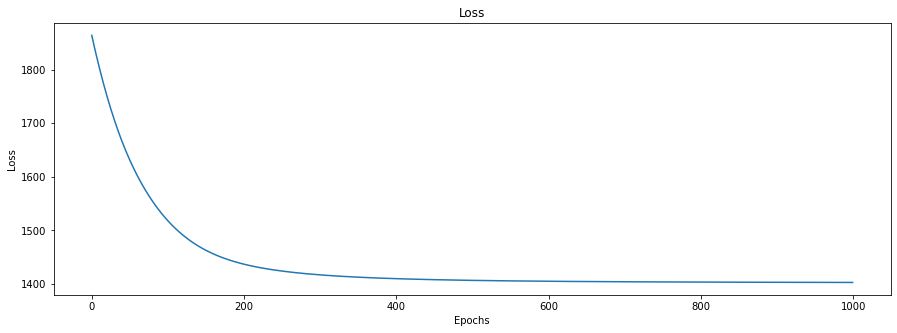

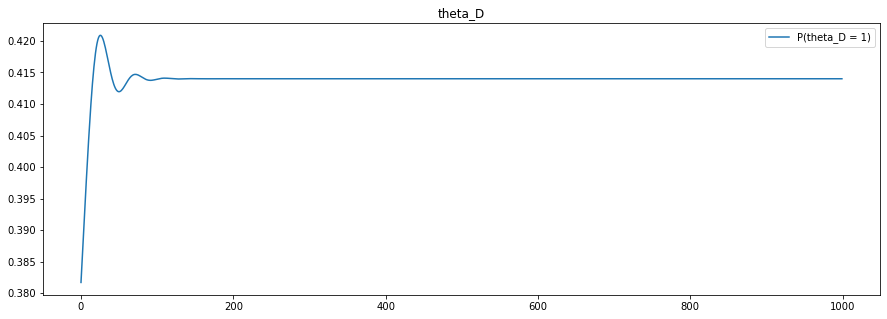

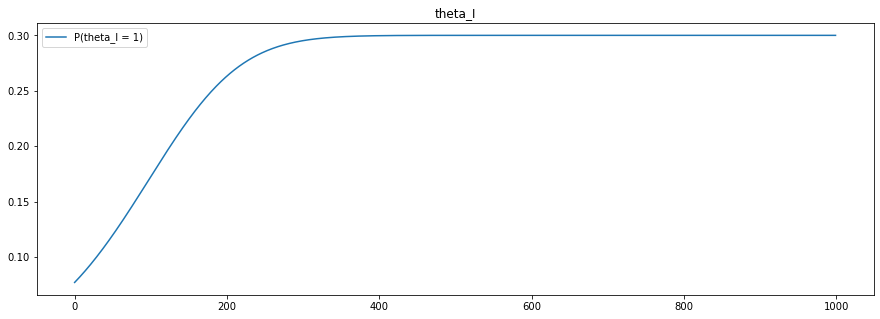

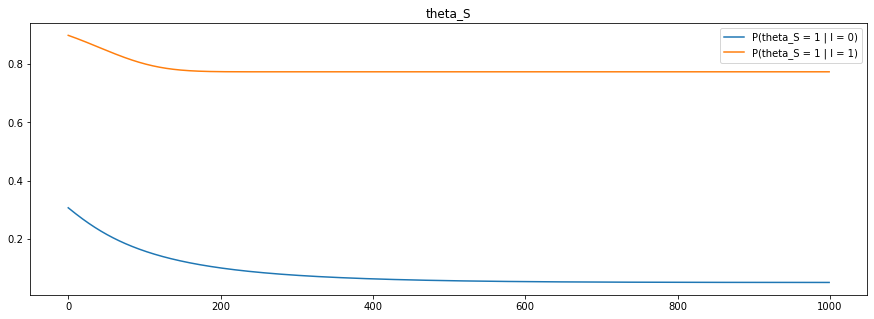

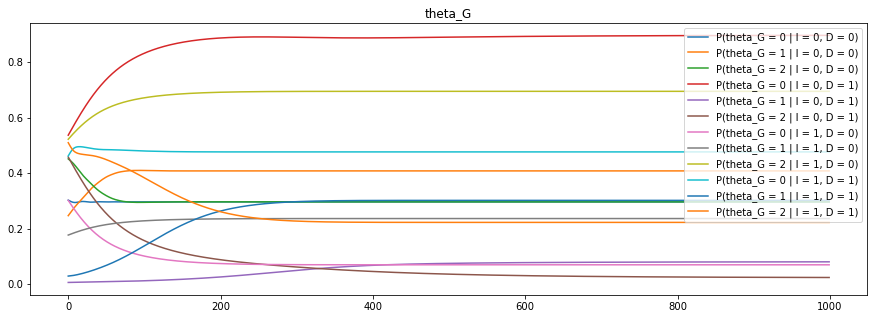

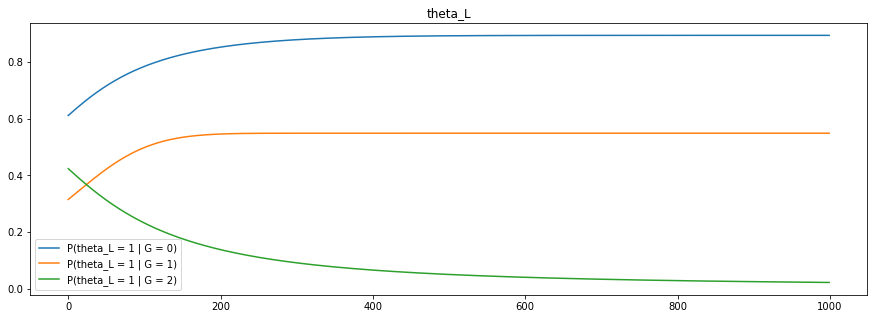

In [6]:
pyro.clear_param_store()
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)
hist = utils.train_svi(model=model, guide=guide, X=x, num_epochs=1_000, lr=1e-2)

utils.visualize_nb_parameters(hist)

In [7]:
for pname, pval in dict(pyro.get_param_store()).items():
    print(pname, pval.detach().numpy())

theta_D [0.414]
theta_I [0.29999992]
theta_S [0.05150065 0.7733334 ]
theta_G [[[0.2961166  0.40776703 0.29611644]
  [0.8961139  0.08016385 0.02372222]]

 [[0.06944449 0.23611109 0.6944444 ]
  [0.4761905  0.30158707 0.22222246]]]
theta_L [0.8938543  0.5486111  0.02203456]


In [21]:
p3 = pyro.param('g3',torch.rand(2,4,2),constraints.simplex)

In [25]:
p3.sum(dim=-2)

tensor([[0.7871, 0.9522, 0.5987, 0.7591, 0.9029],
        [1.0025, 1.3773, 0.7350, 0.4489, 0.4362]], grad_fn=<SumBackward1>)

In [10]:
pyro.sample(f'Difficulty',dist.Bernoulli(p3))

tensor([[1.],
        [0.]])

In [11]:
x=torch.rand(2,1)
x

tensor([[0.3189],
        [0.8069]])

In [12]:
x[0]

tensor([0.3189])

In [13]:
x[1]

tensor([0.8069])

In [14]:
y=pyro.param('SAT_Param')

KeyError: 'SAT_Param'

In [ ]:
x

In [ ]:
x[0]

In [ ]:
x[1]

In [ ]:
param = torch.tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])

In [ ]:
torch.ones(param.shape)*y